In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

class_names = os.listdir(train_dir)

In [3]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+'/'+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

#   return img

Image shape: (150, 150, 3)


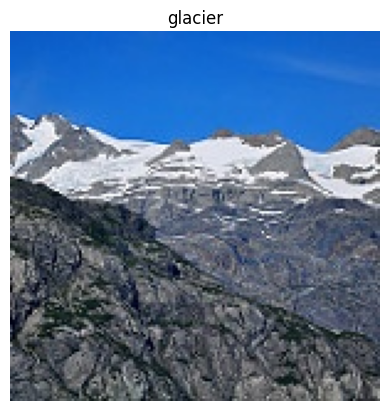

In [4]:
import random

sample_class = random.sample(class_names, 1)[0]
view_random_image(train_dir, sample_class)

In [5]:
for i in class_names:
    curr_path = os.path.join(train_dir, i)
    print(f"{i}, {len(os.listdir(curr_path))}")

mountain, 2512
street, 2382
buildings, 2191
sea, 2274
forest, 2271
glacier, 2404


In [6]:
for i in class_names:
    curr_path = os.path.join(test_dir, i)
    print(f"{i}, {len(os.listdir(curr_path))}")

mountain, 525
street, 501
buildings, 437
sea, 510
forest, 474
glacier, 553


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(150, 150),
                                              class_mode='categorical',
                                              batch_size=32)

val_data = val_datagen.flow_from_directory(directory=test_dir,
                                              target_size=(150, 150),
                                              class_mode='categorical',
                                              batch_size=32)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [9]:
import cv2
import numpy as np

images = []

for file in os.listdir(pred_dir):
    img = cv2.imread(os.path.join(pred_dir, file))
    img = cv2.resize(img, (150, 150))
    img = img / 255.0
    images.append(img)

images = np.array(images)

test_datagen = ImageDataGenerator()
test_data = test_datagen.flow(x=images, batch_size=32)

In [10]:
train_data.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [11]:
val_data.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [12]:
len(class_names)

6

In [13]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

def create_model(input_shape = (150, 150, 3)):

    Inputs = L.Input(shape=input_shape)
    x = L.Conv2D(32, 3, padding="same")(Inputs)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(64, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(128, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Flatten()(x)
    x = L.Dense(512, activation="relu")(x)
    Outputs = L.Dense(len(class_names), activation="softmax")(x)

    model = Model(Inputs, Outputs)
    return model

In [14]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [23]:
# with strategy.scope():
model_1 = create_model()
    
model_1.compile(loss = "categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 37, 128)       7385

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) 

In [24]:
history = model_1.fit(train_data,
                    epochs=6,
                    steps_per_epoch = len(train_data),
                    verbose=1,
                    validation_data = val_data,
                    validation_steps = int(0.25*(len(val_data))),
                    callbacks = [early_stopping])

Epoch 1/50
439/439 [==============================] - 31s 64ms/step - loss: 0.9594 - accuracy: 0.6456 - val_loss: 0.8003 - val_accuracy: 0.7120
Epoch 2/50
439/439 [==============================] - 27s 61ms/step - loss: 0.7061 - accuracy: 0.7445 - val_loss: 0.6242 - val_accuracy: 0.7731
Epoch 3/50
439/439 [==============================] - 27s 61ms/step - loss: 0.5509 - accuracy: 0.8059 - val_loss: 0.6671 - val_accuracy: 0.7541
Epoch 4/50
439/439 [==============================] - 27s 61ms/step - loss: 0.4356 - accuracy: 0.8493 - val_loss: 0.6629 - val_accuracy: 0.7745
Epoch 5/50
439/439 [==============================] - 26s 59ms/step - loss: 0.3242 - accuracy: 0.8924 - val_loss: 0.5492 - val_accuracy: 0.8152
Epoch 6/50
439/439 [==============================] - 25s 56ms/step - loss: 0.2345 - accuracy: 0.9235 - val_loss: 0.6318 - val_accuracy: 0.7853
Epoch 7/50
439/439 [==============================] - 26s 58ms/step - loss: 0.1555 - accuracy: 0.9565 - val_loss: 0.6977 - val_accuracy:

In [25]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

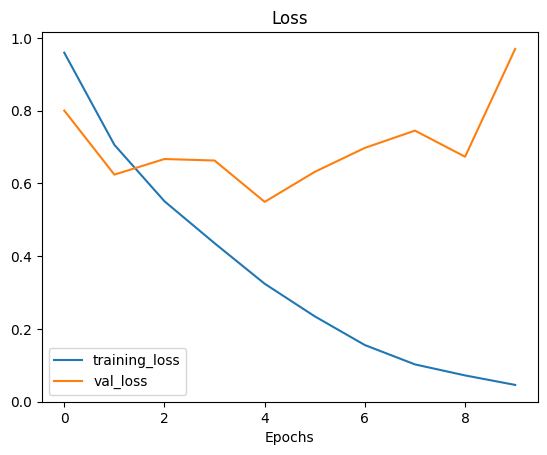

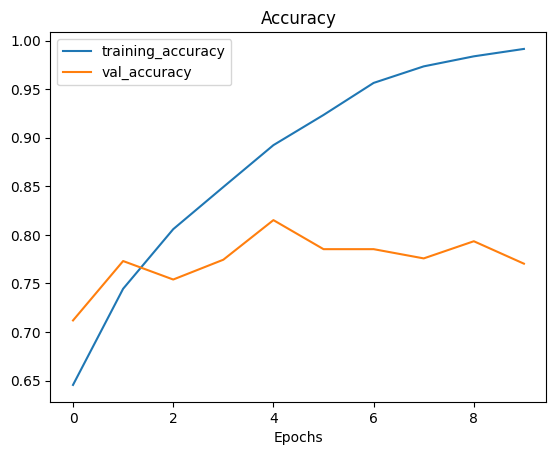

In [26]:
plot_loss_curves(history)

In [32]:
from tensorflow.keras.optimizers import RMSprop

In [36]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
Inputs = L.Input(shape=(150,150,3))
x = base_model(Inputs)
x = L.GlobalAveragePooling2D()(x)
x = L.Dense(512, activation="relu")(x)
Outputs = L.Dense(len(class_names), activation="softmax")(x)

model_2 = Model(Inputs, Outputs, name="transfer_model")

model_2.compile(loss="categorical_crossentropy",
               optimizer=RMSprop(learning_rate=0.001),
               metrics=["accuracy"])

model_2.summary()

Model: "transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dense_12 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 24,639,878
Trainable params: 5,517,830
Non-trainable params: 19,122,048
________________________________

In [37]:
history_2 = model_2.fit(train_data,
                    epochs=10,
                    steps_per_epoch = len(train_data),
                    verbose=1,
                    validation_data = val_data,
                    validation_steps = int(0.25*(len(val_data))))

Epoch 1/10
439/439 [==============================] - 38s 73ms/step - loss: 1.0464 - accuracy: 0.5825 - val_loss: 1.1025 - val_accuracy: 0.6087
Epoch 2/10
439/439 [==============================] - 31s 71ms/step - loss: 0.8267 - accuracy: 0.6801 - val_loss: 2.1078 - val_accuracy: 0.3954
Epoch 3/10
439/439 [==============================] - 31s 71ms/step - loss: 0.7607 - accuracy: 0.7120 - val_loss: 1.5054 - val_accuracy: 0.5231
Epoch 4/10
439/439 [==============================] - 31s 71ms/step - loss: 0.7164 - accuracy: 0.7263 - val_loss: 1.0134 - val_accuracy: 0.6250
Epoch 5/10
439/439 [==============================] - 31s 72ms/step - loss: 0.6741 - accuracy: 0.7442 - val_loss: 1.1333 - val_accuracy: 0.6155
Epoch 6/10
439/439 [==============================] - 33s 74ms/step - loss: 0.6572 - accuracy: 0.7529 - val_loss: 1.0562 - val_accuracy: 0.6141
Epoch 7/10
439/439 [==============================] - 32s 73ms/step - loss: 0.6274 - accuracy: 0.7666 - val_loss: 0.7445 - val_accuracy:

In [73]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = cv2.imread(pred_dir+'/'+filename)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
#     print(tf.round(pred))
#     print(np.argmax(tf.round(pred)))
#     print(class_names[np.argmax(tf.round(pred))])

#     # Get the predicted class
    pred_class = class_names[np.argmax(tf.round(pred))]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [62]:
pred_imgs = os.listdir(pred_dir)
pred_imgs[:5]

['6234.jpg', '22288.jpg', '20529.jpg', '21440.jpg', '5982.jpg']

1/1 [==============================] - 0s 29ms/step


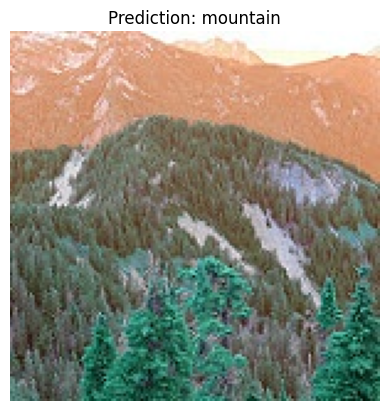

In [81]:
pred_sample = random.sample(pred_imgs, 1)[0]
pred_and_plot(model_2, pred_sample, class_names)